# Load mesh & initialize camera

In [1]:
import trimesh
import xatlas
import torch
import numpy as np
import matplotlib.pylab as plt
from dataclasses import dataclass
from torch.nn.functional import normalize

import nvdiffrast.torch as dr

@dataclass
class Mesh:
    verts: torch.Tensor
    faces: torch.Tensor
    uvs: torch.Tensor
    normals: torch.Tensor
        
def get_normals(verts, faces):
    p_0 = verts[faces[:, 0]]
    p_1 = verts[faces[:, 1]]
    p_2 = verts[faces[:, 2]]
    normals = np.cross(p_1 - p_0, p_2 - p_0, axis=-1)
    normals = normals / (np.linalg.norm(normals, axis=-1, keepdims=True) + 1e-8)
    return normals
        
def load_mesh(filename, device="cuda:0"):
    my_mesh = trimesh.load_mesh(filename)
    vmapping, indices, uvs = xatlas.parametrize(my_mesh.vertices,
                                                my_mesh.faces)

    normals = get_normals(my_mesh.vertices, my_mesh.faces)

    my_mesh = Mesh(
        verts = torch.tensor(my_mesh.vertices[vmapping], dtype=torch.float32, device=device),
        faces = torch.tensor(indices.astype(np.int32), dtype=torch.int32, device=device),
        uvs   = torch.tensor(uvs, dtype=torch.float32, device=device),
        normals = torch.tensor(normals, dtype=torch.float32, device=device)
    )
    return my_mesh

In [2]:
class Camera:
    def __init__(self, batch_size, device, phi=None, theta=None, camera_target=None, r=None):
        if phi is None:
            phi = 0.5 * torch.pi + 0.8 * torch.randn(batch_size)
        if theta is None:
            theta = 0.125 * torch.pi + 0.2 * torch.randn(batch_size)
        if camera_target is None:
            camera_target = torch.tensor([0.0, 0.4, 0.0]).to(device)
        if r is None:
            r = 1.0
        self.camera_location = 2 * r * torch.stack([-phi.cos() * theta.cos(),
                                                    theta.sin(),
                                                    -phi.sin() * theta.cos()], -1).to(device)
        
        y = torch.broadcast_to(torch.eye(3, device=device)[1], self.camera_location.shape)
        z = -normalize(camera_target - self.camera_location, dim=-1)
        x = normalize(torch.cross(z, y), dim=-1)
        y = normalize(torch.cross(x, z), dim=-1)
        
        self.x = x
        self.y = y
        self.z = z
    
    def get_mvp(self,):
        q_t = torch.stack([self.x, self.y, self.z], axis=-2)
        # t = -q_t @ camera_location  <- [4 x 4] * [4]
        t = -(q_t * self.camera_location[:, None]).sum(-1)
        # [b x 4 x 4] * [b, 1, 4]
    
        q_inv = torch.cat([q_t, t[..., None]], axis=-1)
        fourth_row = torch.tensor([0, 0, 0, 1.], device=self.x.device).view(1, 1, -1)
        fourth_row = fourth_row.repeat(q_inv.shape[0], 1, 1)
        q_inv = torch.cat([q_inv, fourth_row], axis=1).to(self.x.device)
    
        n = 0.2
        f = 8.0
        f = 10
        proj = torch.tensor([[f * n,    0,            0,              0],
                             [  0,  - f * n,          0,              0],
                             [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                             [  0,    0,           -1,              0]], device=self.x.device)
        return torch.einsum('ij, bjk->bik', proj, q_inv)

# render the cow

## transform vertices

In [3]:
my_mesh = load_mesh('spot_triangulated.obj')
my_camera = Camera(1, "cuda:0")

In [4]:
def dehomogenize_points(points):
    return points[..., :-1] / points[..., -1:]

def homogenize_points(points):
    last_coordinate = torch.ones_like(points[..., -1:])
    return torch.cat((points, last_coordinate), dim=-1)

In [5]:
mvp_matrix = my_camera.get_mvp()  # b i j

projected_verts = torch.einsum(
    'nj,bij->bni',
    homogenize_points(my_mesh.verts),
    mvp_matrix
)
projected_verts = projected_verts.contiguous()

## rasterize

In [8]:
glctx = dr.RasterizeCudaContext()
rast_out, rast_out_db = dr.rasterize(
    glctx, 
    projected_verts,
    my_mesh.faces,
    resolution=(512, 512)
)

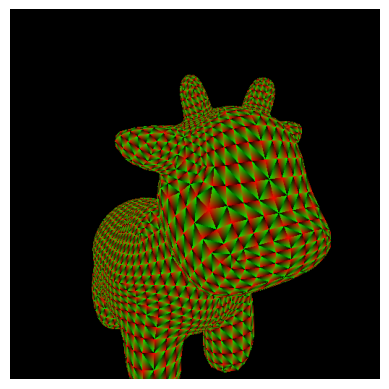

In [9]:
# uvs
uvs = torch.cat([rast_out[0, ..., :2].cpu(), torch.zeros(512, 512, 1)], dim=-1)
plt.imshow(uvs)
plt.axis('off');

(-0.5, 511.5, 511.5, -0.5)

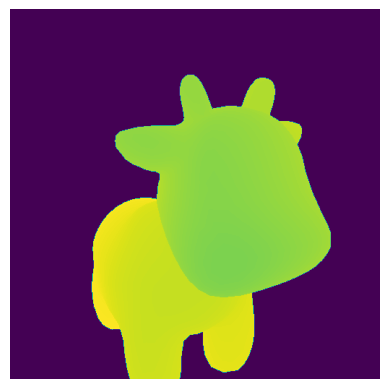

In [10]:
# depth
plt.imshow(rast_out[0, ..., 2].cpu())
plt.axis('off')

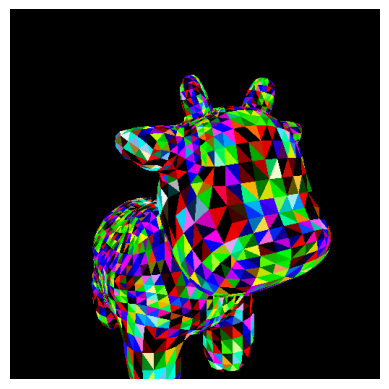

In [11]:
# triangle ids
triangle_ids = rast_out[0, ..., 3]
triangle_ids = torch.stack([
    (123 * triangle_ids).sin(),
    (345 * triangle_ids).sin(),
    (678 * triangle_ids).sin(),
], dim=-1).clip(0., 1.).cpu()
plt.imshow(triangle_ids)
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


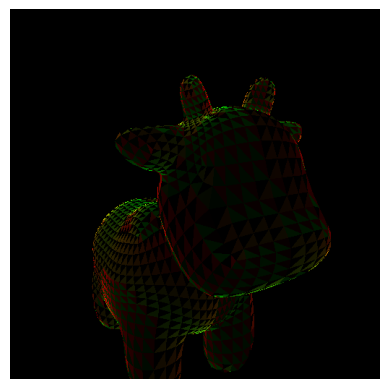

In [12]:
# uvs
db = torch.cat([rast_out_db[0, ..., :2].cpu(), torch.zeros(512, 512, 1)], dim=-1)
plt.imshow(db)
plt.axis('off');

## interpolate, texture & shade

In [13]:
# interpolated attribute & derivatices
texc, texd = dr.interpolate(
        my_mesh.uvs[None, ...],
        rast_out,
        my_mesh.faces,
        rast_db=rast_out_db,
        diff_attrs='all'
)

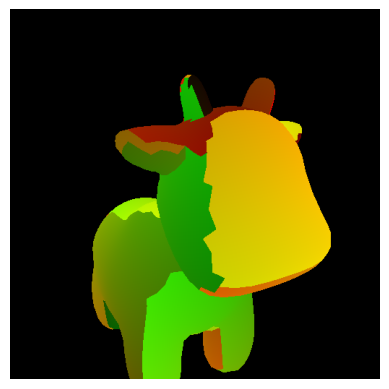

In [14]:
# uvs
uvs = torch.cat([texc[0, ..., :2].cpu(), torch.zeros(512, 512, 1)], dim=-1)
plt.imshow(uvs)
plt.axis('off');

(-0.5, 31.5, 31.5, -0.5)

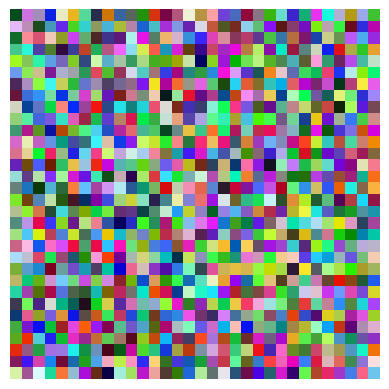

In [15]:
texture = torch.rand(32, 32, 3, device=torch.device('cuda:0'))
plt.imshow(texture.cpu())
plt.axis('off')

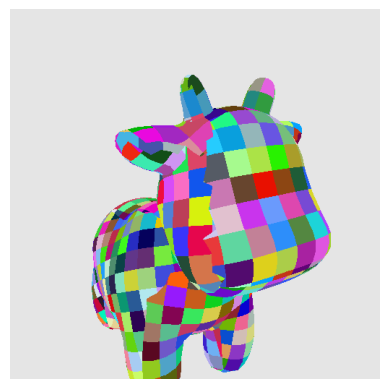

In [16]:
projected_texture = dr.texture(
        texture[None, ...],
        texc,
        texd,
        filter_mode='nearest',
        max_mip_level=9
)

image = projected_texture
mask = torch.clamp(rast_out[..., -1:], 0, 1)
image = torch.where(mask == 1, projected_texture, torch.tensor(0.9))

plt.imshow(image[0].cpu())
plt.axis('off');

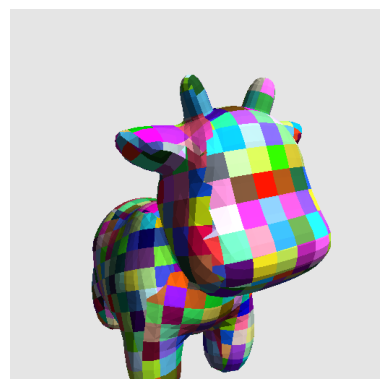

In [17]:
triangle_ids = (rast_out[..., 3].clamp(1.) - 1.).to(torch.long)
normals = my_mesh.normals[triangle_ids]
light_dir = torch.tensor([0., 1., -1.], device=torch.device('cuda:0'))
ligtt_dir = light_dir / light_dir.norm()

diffuse_coefficient = (normals * light_dir).sum(-1, keepdim=True).clamp(0.3)
image = (
        diffuse_coefficient * projected_texture
).clamp(0., 1.)
mask = torch.clamp(rast_out[..., -1:], 0, 1)
image = torch.where(mask == 1, image, torch.tensor(0.9))

plt.imshow(image[0].cpu())
plt.axis('off');

# trying optimization

In [18]:
def transform_pos(mvp, pos):
    posw = homogenize_points(pos)
    return torch.einsum('nj,bij->bni', posw, mvp)

def render(texture, model, camera, light_dir, filter_mode='linear-mipmap-linear', resolution=(512, 512), max_mip_level=9):
    # project vertices
    mvp = camera.get_mvp()
    pos_clip = transform_pos(mvp, model.verts)
    pos_clip = pos_clip.contiguous()
    # start rasterization
    glctx = dr.RasterizeCudaContext()
    rast_out, rast_out_db = dr.rasterize(glctx, pos_clip, model.faces, resolution=resolution)

    texc, texd = dr.interpolate(
        model.uvs[None, ...],
        rast_out,
        model.faces,
        rast_db=rast_out_db,
        diff_attrs='all'
    )
    projected_texture = dr.texture(
        texture[None, ...],
        texc,
        texd,
        filter_mode=filter_mode,
        max_mip_level=max_mip_level
    )
    projected_texture = dr.antialias(projected_texture, rast_out, pos_clip, model.faces)
    
    mask = torch.clamp(rast_out[..., -1:], 0, 1)
    triangle_ids = (rast_out[..., 3].clamp(1.) - 1.).to(torch.long)
    normals = model.normals[triangle_ids]
    
    diffuse_albedo = projected_texture[..., :3]
    light_dir = light_dir.view(-1, 1, 1, 3)
    diffuse_coefficient = (normals * light_dir).sum(-1, keepdim=True).clamp(0.) + 0.3
    output_color = (
        diffuse_coefficient * diffuse_albedo
    ).clamp(0., 1.)
    return torch.where(mask == 1, output_color, torch.tensor(0.9))

In [19]:
my_camera = Camera(32, "cuda:0")
texture = torch.rand(32, 32, 3, device="cuda:0")
light_dir = torch.tensor([0., 0., -1.], device="cuda:0")

reference_images = render(texture, my_mesh, my_camera, light_dir, filter_mode='nearest')

(-0.5, 511.5, 511.5, -0.5)

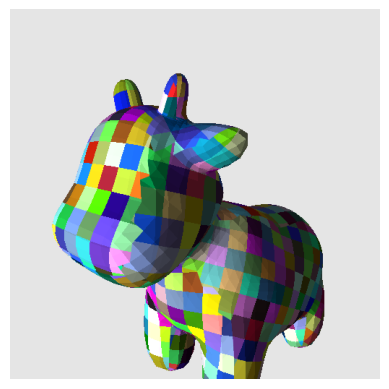

In [20]:
plt.imshow(reference_images[0].detach().cpu())
plt.axis('off')

In [22]:
trained_texture = torch.nn.Parameter(0.5 + torch.zeros(512, 512, 3, device=torch.device('cuda:0')))
predicted_images = render(trained_texture, my_mesh, my_camera, light_dir, filter_mode='nearest')
predicted_images.requires_grad

True

In [24]:
from tqdm.notebook import trange, tqdm

optimizer = torch.optim.Adam([trained_texture], lr=0.001)
t = trange(1024, desc='Bar desc', leave=True)

for i in t:
    predicted_images = render(trained_texture, my_mesh, my_camera, light_dir, filter_mode='nearest')
    loss = ((reference_images - predicted_images) ** 2).mean(0).sum()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    trained_texture.data = trained_texture.data.clamp(0., 1.)
    
    t.set_description(f"Step #{i}, Loss: {loss.detach().cpu():.5f}")
    t.refresh() # to show immediately the update

Bar desc:   0%|          | 0/1024 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Optimized')

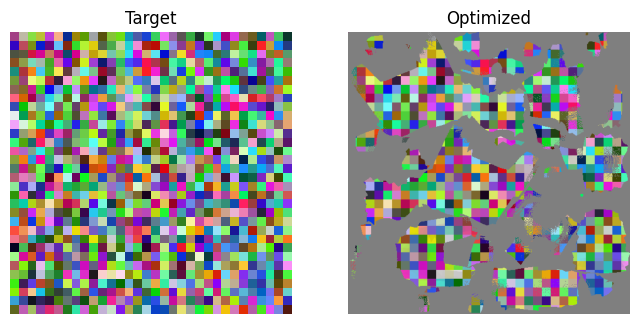

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(texture.cpu())
axs[0].axis('off')
axs[0].set_title('Target')
axs[1].imshow(trained_texture.detach().cpu())
axs[1].axis('off');
axs[1].set_title('Optimized')